<a href="https://colab.research.google.com/github/aSafarpoor/GNN-materials/blob/main/Test_Idea_of_GCN_node_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is mainly not mine but, I will add some parts to make it like a tutorial for myself, and then |I will change it to test my idea.

Based on: https://towardsdatascience.com/program-a-simple-graph-net-in-pytorch-e00b500a642d

Source: https://github.com/praxidike97/GraphNeuralNet/blob/72c330bb6e64dd7dd6784b6e69a821149dc5d028/main.py#L114

In [190]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [191]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# pure model

In [192]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j

In [235]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv2 = GCNConv(32, dataset.num_classes)


    def forward(self, data):

        x, edge_index = data.x, data.edge_index
        
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

## *****************************************************

In [222]:
#based on https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/

# Python program to print connected
# components in an undirected graph


class Graph:

	# init function to declare class variables
	def __init__(self, V):
		self.V = V
		self.adj = [[] for i in range(V)]

	def DFSUtil(self, temp, v, visited):

		# Mark the current vertex as visited
		visited[v] = True

		# Store the vertex to list
		temp.append(v)

		# Repeat for all vertices adjacent
		# to this vertex v
		for i in self.adj[v]:
			if visited[i] == False:

				# Update the list
				temp = self.DFSUtil(temp, i, visited)
		return temp

	# method to add an undirected edge
	def addEdge(self, v, w):
		self.adj[v].append(w)
		self.adj[w].append(v)

	# Method to retrieve connected components
	# in an undirected graph
	def connectedComponents(self):
		visited = []
		cc = []
		for i in range(self.V):
			visited.append(False)
		for v in range(self.V):
			if visited[v] == False:
				temp = []
				cc.append(self.DFSUtil(temp, v, visited))
		return cc

In [195]:
# # Driver Code
# g = Graph(x.shape[0])
# for i in tqdm(range(len(edge_index[0]))):
#     g.addEdge(edge_index[0][i],edge_index[1][i])

# cc = g.connectedComponents()
# print("Following are connected components")
# print(cc)

In [196]:
# for i in range(len(cc)):
#     print(i,"--> ",len(cc[i]))

## *************************************************

In [197]:
def plot_dataset(dataset):
    edges_raw = dataset.data.edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labels = dataset.data.y.numpy()

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edges_raw))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 30,
                'width': 0.2,
    }
    nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
    plt.show()

In [198]:
def test(model,data, train=True):
    model.eval()

    correct = 0
    pred = model(data).max(dim=1)[1]

    if train:
        correct += pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
        return correct / (len(data.y[data.train_mask]))
    else:
        correct += pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        return correct / (len(data.y[data.test_mask]))


In [199]:
def train(model,data, plot=False):
    train_accuracies, test_accuracies = list(), list()
    for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            train_acc = test(model,data)
            test_acc = test(model,data, train=False)

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc))

    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("# Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()

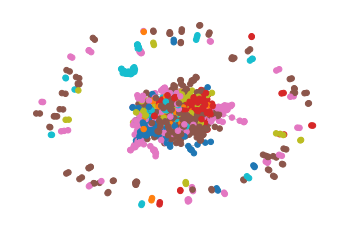

In [271]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

plot_dataset(dataset)

In [201]:
print(type(dataset))

edges_raw = dataset.data.edge_index.numpy()
edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]

print('edges_raw:  ',edges_raw)
print('edges:      ',edges)

labels = dataset.data.y.numpy()
print('labelsL:    ',labels)
print('len_of_set: ',len(set(labels)))

<class 'torch_geometric.datasets.planetoid.Planetoid'>
edges_raw:   [[   0    0    0 ... 2707 2707 2707]
 [ 633 1862 2582 ...  598 1473 2706]]
edges:       [(0, 633), (0, 1862), (0, 2582), (1, 2), (1, 652), (1, 654), (2, 1), (2, 332), (2, 1454), (2, 1666), (2, 1986), (3, 2544), (4, 1016), (4, 1256), (4, 1761), (4, 2175), (4, 2176), (5, 1629), (5, 1659), (5, 2546), (6, 373), (6, 1042), (6, 1416), (6, 1602), (7, 208), (8, 269), (8, 281), (8, 1996), (9, 723), (9, 2614), (10, 476), (10, 2545), (11, 1655), (11, 1839), (12, 1001), (12, 1318), (12, 2661), (12, 2662), (13, 1701), (13, 1810), (14, 158), (14, 2034), (14, 2075), (14, 2077), (14, 2668), (15, 1090), (15, 1093), (15, 1271), (15, 2367), (16, 970), (16, 1632), (16, 2444), (16, 2642), (17, 24), (17, 927), (17, 1315), (17, 1316), (17, 2140), (18, 139), (18, 1560), (18, 1786), (18, 2082), (18, 2145), (19, 1939), (20, 1072), (20, 2269), (20, 2270), (20, 2374), (20, 2375), (21, 1043), (21, 2310), (22, 39), (22, 1234), (22, 1702), (22, 1703

In [202]:
G = nx.Graph()
G.add_nodes_from(list(range(np.max(edges_raw))))
G.add_edges_from(edges)

In [203]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [204]:
model = Net(dataset).to(device)
model

Net(
  (conv1): GCNConv()
  (conv2): GCNConv()
)

In [272]:
data = dataset[0].to(device)
print(data)
x, edge_index = data.x, data.edge_index
print(len(x[0]),x.shape)
print(edge_index,edge_index.shape)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
1433 torch.Size([2708, 1433])
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]], device='cuda:0') torch.Size([2, 10556])


In [206]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

## train phase

In [207]:
model.train()
optimizer.zero_grad()

In [208]:
out = model(data)
out.shape,out[0]

(torch.Size([2708, 7]),
 tensor([-1.9410, -2.0043, -1.9065, -1.9359, -1.8822, -2.0479, -1.9138],
        device='cuda:0', grad_fn=<SelectBackward0>))

nll_loss: negative log likelihood loss.

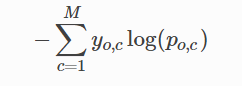



In [209]:
type(data)

torch_geometric.data.data.Data

In [210]:
len(data.train_mask),sum(data.train_mask==True),sum(data.train_mask==False)

(2708, tensor(140, device='cuda:0'), tensor(2568, device='cuda:0'))

In [211]:
loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

In [ ]:
train(model,data, plot=True)

Test

In [217]:
def test_(model,data, plot=False):
    train_accuracies, test_accuracies = list(), list()
    
    # model.train()
    # optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    # loss.backward()
    # optimizer.step()

    train_acc = test(model,data)
    test_acc = test(model,data, train=False)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print('Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
            format(loss, train_acc, test_acc))

    

In [218]:
test_(model,data)

Loss: 0.00968, Train Acc: 1.00000, Test Acc: 0.80900


# test different models

## fist model: **Raw GCN**

In [219]:
model1 = Net(dataset).to(device)
model1

Net(
  (conv1): GCNConv()
  (conv2): GCNConv()
)

In [220]:
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)

Epoch: 000, Loss: 1.95853, Train Acc: 0.16429, Test Acc: 0.10700
Epoch: 001, Loss: 1.88890, Train Acc: 0.55000, Test Acc: 0.30800
Epoch: 002, Loss: 1.78353, Train Acc: 0.62143, Test Acc: 0.42300
Epoch: 003, Loss: 1.67124, Train Acc: 0.75714, Test Acc: 0.50600
Epoch: 004, Loss: 1.52729, Train Acc: 0.87143, Test Acc: 0.59000
Epoch: 005, Loss: 1.40871, Train Acc: 0.89286, Test Acc: 0.66300
Epoch: 006, Loss: 1.24457, Train Acc: 0.95000, Test Acc: 0.72000
Epoch: 007, Loss: 1.09913, Train Acc: 0.96429, Test Acc: 0.75000
Epoch: 008, Loss: 0.93960, Train Acc: 0.96429, Test Acc: 0.77800
Epoch: 009, Loss: 0.81601, Train Acc: 0.97143, Test Acc: 0.78500
Epoch: 010, Loss: 0.68775, Train Acc: 0.97143, Test Acc: 0.79400
Epoch: 011, Loss: 0.59539, Train Acc: 0.97857, Test Acc: 0.79700
Epoch: 012, Loss: 0.52887, Train Acc: 0.97857, Test Acc: 0.79400
Epoch: 013, Loss: 0.41171, Train Acc: 0.98571, Test Acc: 0.79600
Epoch: 014, Loss: 0.34942, Train Acc: 0.98571, Test Acc: 0.79300
Epoch: 015, Loss: 0.27095

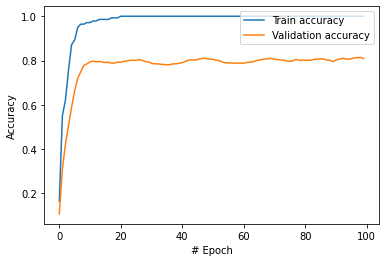

Loss: 0.01070, Train Acc: 1.00000, Test Acc: 0.80900


In [221]:
model1.train()
optimizer.zero_grad()
out = model1(data)
loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

train(model1,data,True)
test_(model1,data)

## seconde model: **raw light GNN >> raw GNN**

In [288]:
data = dataset[0].to(device)
x, edge_index = data.x, data.edge_index

In [289]:
# Driver Code
g = Graph(x.shape[0])
for i in tqdm(range(len(edge_index[0]))):
    g.addEdge(edge_index[0][i],edge_index[1][i])

cc = g.connectedComponents()
print("Following are connected components")
print(cc)

100%|██████████| 10556/10556 [00:00<00:00, 12886.11it/s]


Following are connected components
[[0, tensor(633, device='cuda:0'), tensor(1701, device='cuda:0'), tensor(13, device='cuda:0'), tensor(1810, device='cuda:0'), tensor(27, device='cuda:0'), tensor(606, device='cuda:0'), tensor(531, device='cuda:0'), tensor(2308, device='cuda:0'), tensor(159, device='cuda:0'), tensor(180, device='cuda:0'), tensor(158, device='cuda:0'), tensor(14, device='cuda:0'), tensor(2034, device='cuda:0'), tensor(49, device='cuda:0'), tensor(1666, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(652, device='cuda:0'), tensor(470, device='cuda:0'), tensor(854, device='cuda:0'), tensor(203, device='cuda:0'), tensor(857, device='cuda:0'), tensor(1097, device='cuda:0'), tensor(1115, device='cuda:0'), tensor(593, device='cuda:0'), tensor(415, device='cuda:0'), tensor(88, device='cuda:0'), tensor(76, device='cuda:0'), tensor(2018, device='cuda:0'), tensor(356, device='cuda:0'), tensor(211, device='cuda:0'), tensor(164, device='cuda:0'), te

In [290]:
for i in range(len(cc)):
    if len(cc[i])>2:
        print(i,"--> ",len(cc[i]))

0 -->  2485
3 -->  5
4 -->  26
5 -->  8
7 -->  4
9 -->  9
11 -->  3
12 -->  6
15 -->  3
21 -->  3
23 -->  4
24 -->  4
26 -->  3
28 -->  3
32 -->  4
37 -->  5
41 -->  3
50 -->  3
51 -->  4
68 -->  5
76 -->  4


In [291]:
import random
random.seed(10)

In [292]:
def commponent_contrastive(data,cc,th=0.5,lambdaa=0.1):
    x = data.x
    ncc = len(cc)

    for i in range(ncc):
        if random.random()>th:
            randi1 = random.choice(cc[i])
        
            temp = random.randint(0,ncc-1)
            while(i == temp):
                temp = random.randint(0,ncc-1)

            randi2 = random.choice(cc[temp])
            temp = x[randi1][:] 
            x[randi1] = -lambdaa*(x[randi2])
            x[randi2] = -lambdaa*(temp)
    data.x = x

    return data

In [285]:
# data2 = commponent_contrastive(data,cc,0.5,0.2)

In [341]:
class Net2(torch.nn.Module):
    def __init__(self, dataset):
        super(Net2, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv2 = GCNConv(32, dataset.num_classes)


    def forward(self, data):

        data = commponent_contrastive(data,cc,0.05,0.005)

        x, edge_index = data.x, data.edge_index
        
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

Epoch: 000, Loss: 1.95089, Train Acc: 0.37143, Test Acc: 0.28800
Epoch: 001, Loss: 1.89594, Train Acc: 0.69286, Test Acc: 0.50500
Epoch: 002, Loss: 1.80700, Train Acc: 0.77143, Test Acc: 0.56500
Epoch: 003, Loss: 1.71050, Train Acc: 0.77143, Test Acc: 0.57900
Epoch: 004, Loss: 1.58317, Train Acc: 0.78571, Test Acc: 0.59300
Epoch: 005, Loss: 1.46017, Train Acc: 0.82143, Test Acc: 0.61100
Epoch: 006, Loss: 1.33198, Train Acc: 0.83571, Test Acc: 0.63900
Epoch: 007, Loss: 1.21276, Train Acc: 0.86429, Test Acc: 0.65800
Epoch: 008, Loss: 1.10287, Train Acc: 0.87857, Test Acc: 0.68900
Epoch: 009, Loss: 0.99222, Train Acc: 0.88571, Test Acc: 0.70400
Epoch: 010, Loss: 0.85977, Train Acc: 0.90714, Test Acc: 0.71700
Epoch: 011, Loss: 0.81190, Train Acc: 0.92143, Test Acc: 0.72100
Epoch: 012, Loss: 0.71037, Train Acc: 0.92143, Test Acc: 0.73100
Epoch: 013, Loss: 0.63281, Train Acc: 0.93571, Test Acc: 0.74300
Epoch: 014, Loss: 0.53527, Train Acc: 0.93571, Test Acc: 0.74400
Epoch: 015, Loss: 0.50288

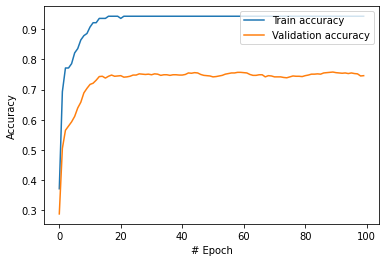

Loss: 0.18342, Train Acc: 0.94286, Test Acc: 0.74500


In [342]:
data = dataset[0].to(device)
x, edge_index = data.x, data.edge_index

model2 = Net2(dataset).to(device)
# model2

optimizer = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)


model2.train()
optimizer.zero_grad()
out = model2(data)
loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])


# data = commponent_contrastive(data,cc,0.5,0.1)
# data = commponent_contrastive(data,cc,0.5,0.1)
# data = commponent_contrastive(data,cc,0.5,0.1)
# data = commponent_contrastive(data,cc,0.5,0.1)

train(model2,data,True)
test_(model2,data)